# SuStaIn tutorial using simulated data

Written by Alex Young in April 2020, updated in April 2021. Please email alexandra.young@kcl.ac.uk with any questions.

This tutorial demonstrates how to run Subtype and Stage Inference (SuStaIn) using simulated data. SuStaIn is an unsupervised learning algorithm that identifies subgroups of individuals with distinct biomarker progression patterns. See [Young et al. Nature Communications 2018](https://doi.org/10.1038/s41467-018-05892-0) for more details.

SuStaIn is a generalisable algorithm in which you can choose how to model the progression of biomarkers within a subtype. In this tutorial I use the linear z-score model I used in [Young et al. 2018](https://doi.org/10.1038/s41467-018-05892-0), but it is possible to use other models of biomarker evolution, such as the event-based model.

## Installing SuStaIn and setting it up to run in a notebook

To get SuStaIn up and running first you need to install the package. I'm using Anaconda and had some conflicts with existing packagaes so I had to create a new environment and set it up to be accessible from a jupyter notebook. For me the whole set up process looked like this...

Step 1: Create a new environment "sustain_env" in anaconda that uses python 3.7 and activate the environment ready to install pySuStaIn.
```console
conda create --name sustain_env python=3.7
conda activate sustain_env
```

Step 2: Install pySuStaIn within the environment. The first line installs the kde-ebm (not needed for this tutorial), and the second line installs pySutaIn. Using the -e option enables you to edit the code (most users won't need to do this so can remove the -e). 
```console
pip install -e ./awkde
pip install -e .
```

Step 3: To get the new environment to run inside a notebook I had to install ipykernel and use that to add the environment as a new kernel.
```console
conda install ipykernel
python3.7 -m ipykernel install --user --name sustain_env
```

When running the notebook you then need to make sure you're using the new kernel (it should appear as sustain_env in the top right hand corner, or you need to select it using Kernel>Change kernel>sustain_env).

## Importing packages

In [1]:
# import the python packages needed to generate simulated data for the tutorial
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import sklearn.model_selection
import pandas as pd
import pylab
import sys
import pySuStaIn

sys.path.insert(0,'../sim/')
from simfuncs import generate_random_Zscore_sustain_model, generate_data_Zscore_sustain

## The linear z-score model

The linear z-score model I use in this tutorial describes a subtype progression pattern as the linear evolution of biomarkers between different z-scores. Figure 1 below shows an example of what this model looks like for a single subtype. The model is indexed by a set of discrete stages. Each stage corresponds to a biomarker reaching a new z-score from the set of z-scores for each biomarker, Z_vals. Each biomarker starts with a minimum value of 0 at stage 0 and reaches a maximum of Z_max at the final stage of the progression. The number of stages is determined by the number of biomarkers and z-scores in Z_vals. The SuStaIn algorithm identifies subgroups of individuals and their progression patterns - for the linear z-score model the progression pattern would be the ordering of the different biomarker z-scores in Z_vals - gt_sequence below.

You can play around generating different sequences and altering the settings of the linear z-score model using the code below.

Simulated sequence: [ 1  3  7  2 10  0  4  6  8  9 11  5]
At the beginning of the progression (stage 0) the biomarkers have scores of 0
At the stages: [ 1  2  3  4  5  6  7  8  9 10 11 12]
the biomarkers: [1 3 3 2 3 0 4 1 4 1 4 0]
reach z-scores of: [1 1 2 1 3 1 1 2 2 3 3 2]
At the end of the progression (stage 14 ) the biomarkers reach scores of: [3 5 2 5 5]
The z-score model assumes individuals belong to some unknown stage of this progression,
with gaussian noise with a standard deviation of 1 for each biomarker


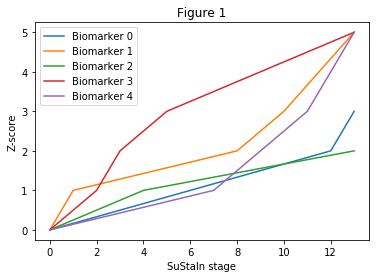

In [2]:
N                       = 5         # number of biomarkers

SuStaInLabels           = []
for i in range(N):
        SuStaInLabels.append( 'Biomarker '+str(i)) # labels of biomarkers for plotting
        
Z_vals                  = np.array([[1,2,3]]*N)     # Z-scores for each biomarker
Z_max                   = np.array([5]*N)           # maximum z-score

# To demonstrate how to set different biomarkers to have different z-scores,
# set biomarker 0 to have z-scores of 1 and 2 only and a maximum of 3
# to do this change the corresponding row of Z_vals to read 1 2 0
# and change the corresponding row of Z_max to 3
Z_vals[np.array(0),np.array(2)] = 0
Z_max[np.array(0)] = 3

# and set biomarker 2 to have a z-score of 1 only and a maximum of 2
# to do this change the corresponding row of Z_vals to read 1 0 0 
# and change the corresponding row of Z_max to 2 
Z_vals[np.array(2),np.array([1,2])] = 0
Z_max[np.array(2)] = 2


# generate a random sequence for the linear z-score model
gt_sequence             = generate_random_Zscore_sustain_model(Z_vals,
                                                        1)

# ignore this part, it's only necessary so that the generate_data_sustain function
# can be used in this demo setting
gt_stages = np.array([0])
gt_subtypes = np.array([0])

# this code generates data from z-score sustain 
# - here i've just output the z-score model itself rather than any datapoints
_, _, gt_stage_value = generate_data_Zscore_sustain(gt_subtypes,
                                             gt_stages,
                                             gt_sequence,
                                             Z_vals,
                                             Z_max)

# ignore this part, just calculates some parameters of sustain to output below
stage_zscore            = np.array([y for x in Z_vals.T for y in x])
stage_zscore            = stage_zscore.reshape(1,len(stage_zscore))
IX_select               = stage_zscore>0
stage_zscore            = stage_zscore[IX_select]
stage_zscore            = stage_zscore.reshape(1,len(stage_zscore))
num_zscores             = Z_vals.shape[1]
IX_vals                 = np.array([[x for x in range(N)]] * num_zscores).T
stage_biomarker_index   = np.array([y for x in IX_vals.T for y in x])
stage_biomarker_index   = stage_biomarker_index.reshape(1,len(stage_biomarker_index))
stage_biomarker_index   = stage_biomarker_index[IX_select]
stage_biomarker_index   = stage_biomarker_index.reshape(1,len(stage_biomarker_index))

# print out some of the values and plot a picture of the model
print('Simulated sequence:',(gt_sequence.astype(int).flatten()))
print('At the beginning of the progression (stage 0) the biomarkers have scores of 0')
print('At the stages:',1+np.arange(np.array(stage_zscore).shape[1]))
print('the biomarkers:',stage_biomarker_index[:,gt_sequence.astype(int).flatten()].flatten())
print('reach z-scores of:',stage_zscore[:,gt_sequence.astype(int).flatten()].flatten())
print('At the end of the progression (stage',np.array(stage_zscore).shape[1]+2,') the biomarkers reach scores of:',Z_max)
print('The z-score model assumes individuals belong to some unknown stage of this progression,')
print('with gaussian noise with a standard deviation of 1 for each biomarker')

temp_stages = np.array(range(np.array(stage_zscore).shape[1]+2))
for b in range(N):
    ax = plt.plot(temp_stages, gt_stage_value[b,:,:])

_ = plt.xlabel('SuStaIn stage')    
_ = plt.ylabel('Z-score')    
_ = plt.legend(SuStaInLabels)
_ = plt.title('Figure 1')

## Important note on the linear z-score model

It's natural to think of the progression pattern in Figure 1 as linear in time but this isn't necessarily the case. For example, the time between stages 2 and 3 may be much longer than between stages 8 and 9. This means that the shape of the trajectories may look quite different if indexed by time (although the general order in which the biomarkers progress to different z-scores would remain the same). The linear z-score model simply describes the patient snapshots you would expect to see in a cross-sectional dataset for any particular subtype at a particular stage. The subtypes and stages are considered as hidden variables, which the SuStaIn algorithm identifies directly from the data.

## Generating simulated data

This section of code generates simulated data for the tutorial. Any variables labelled as 'gt' (ground truth) are for generating the simulated data only and would typically not be known beforehand in a real dataset.

You can ignore many of the settings below for now, but in particular
- N_S_gt is the number of subtypes to simulate
- gt_f is the proportion of individuals belonging to each subtype
- gt_sequence is the order in which each biomarker approaches each z-score for each subtype
- gt_subtypes is the subtype of each individual
- gt_stages is the stage of each individual along the progression pattern of their subtype

You can alter these to get a feel for how SuStaIn works on different simulated datasets.

In [3]:
N                       = 5         # number of biomarkers
M                       = 500       # number of observations ( e.g. subjects )
M_control               = 100       # number of these that are control subjects
N_S_gt                  = 2         # number of ground truth subtypes

SuStaInLabels           = []
for i in range(N):
        SuStaInLabels.append( 'Biomarker '+str(i)) # labels of biomarkers for plotting
        
Z_vals                  = np.array([[1,2,3]]*N)     # Z-scores for each biomarker
Z_max                   = np.array([5]*N)           # maximum z-score
   
# ground truth proportion of individuals belonging to each subtype    
gt_f                    = [1+0.5*x for x in range(N_S_gt)]
gt_f                    = [x/sum(gt_f) for x in gt_f][::-1]

# ground truth sequence for each subtype
gt_sequence             = generate_random_Zscore_sustain_model(Z_vals,
                                                        N_S_gt)

# simulate subtypes and stages for individuals, including a control population at stage 0
N_k                     = np.sum(Z_vals>0)+1
gt_subtypes             = np.random.choice(range(N_S_gt), M, replace=True, p=gt_f)
gt_stages_control       = np.zeros((M_control,1))
gt_stages               = np.concatenate((gt_stages_control,
                                         np.ceil(np.random.rand(M-M_control,1)*N_k)),
                                        axis=0)

# generate simulated data
data, gt_data_denoised, gt_stage_value = generate_data_Zscore_sustain(gt_subtypes,
                                                               gt_stages,
                                                               gt_sequence,
                                                               Z_vals,
                                                               Z_max)

# ignore this part, just calculates some parameters of sustain to output below
stage_zscore            = np.array([y for x in Z_vals.T for y in x])
stage_zscore            = stage_zscore.reshape(1,len(stage_zscore))
IX_select               = stage_zscore>0
stage_zscore            = stage_zscore[IX_select]
stage_zscore            = stage_zscore.reshape(1,len(stage_zscore))
num_zscores             = Z_vals.shape[1]
IX_vals                 = np.array([[x for x in range(N)]] * num_zscores).T
stage_biomarker_index   = np.array([y for x in IX_vals.T for y in x])
stage_biomarker_index   = stage_biomarker_index.reshape(1,len(stage_biomarker_index))
stage_biomarker_index   = stage_biomarker_index[IX_select]
stage_biomarker_index   = stage_biomarker_index.reshape(1,len(stage_biomarker_index))

for s in range (N_S_gt):
    # print out the parameters
    print('For subtype',s,'(',gt_f[s]*100,'% of individuals)')
    print('Simulated sequence:',(gt_sequence[s,:].astype(int).flatten()))
    print('At the beginning of the progression (stage 0) the biomarkers have scores of 0')
    print('At the stages:',1+np.arange(np.array(stage_zscore).shape[1]))
    print('the biomarkers:',stage_biomarker_index[:,gt_sequence[s,:].astype(int).flatten()].flatten())
    print('reach z-scores of:',stage_zscore[:,gt_sequence[s,:].astype(int).flatten()].flatten())
    print('At the end of the progression (stage',np.array(stage_zscore).shape[1]+2,') the biomarkers reach scores of:',Z_max)
    print('')

For subtype 0 ( 60.0 % of individuals)
Simulated sequence: [ 1  3  0  2  8  6  7 12 11  4 13  9 14  5 10]
At the beginning of the progression (stage 0) the biomarkers have scores of 0
At the stages: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
the biomarkers: [1 3 0 2 3 1 2 2 1 4 3 4 4 0 0]
reach z-scores of: [1 1 1 1 2 2 2 3 3 1 3 2 3 2 3]
At the end of the progression (stage 17 ) the biomarkers reach scores of: [5 5 5 5 5]

For subtype 1 ( 40.0 % of individuals)
Simulated sequence: [ 4  0  2  7 12  9 14  1  5  6 11  3 10  8 13]
At the beginning of the progression (stage 0) the biomarkers have scores of 0
At the stages: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
the biomarkers: [4 0 2 2 2 4 4 1 0 1 1 3 0 3 3]
reach z-scores of: [1 1 1 2 3 2 3 1 2 2 3 1 3 2 3]
At the end of the progression (stage 17 ) the biomarkers reach scores of: [5 5 5 5 5]



## The SuStaIn algorithm

SuStaIn identifies subtypes with distinct progression patterns from cross-sectional data. The algorithm proceeds hierarchically, first fitting a single subtype to the data, then two, then three, etc., up to a maximum number of subtypes chosen by the user. The fitting of the nth subtype model works but splitting each of the previous n-1 clusters into two and then using this as an initialisation to fit the n subtype model. For each of the n subtype models, SuStaIn uses MCMC sampling to estimate the uncertainty in the subtype progression patterns and the proportion of individuals that belong to each subtype. The optimal number of subtypes is selected by using cross-validation to compute the cross-validation information criterion (CVIC).

## Preparing data for SuStaIn

The data for SuStaIn needs to be z-scored relative to a control population such that the mean of the control population is 0 and the standard deviation of the control population is 1. To do this simply subtract the mean of the control population from your data and divide by the standard deviation of the control population. Double check that if you apply this transformation to the control population only that the control population has a mean of 0 and a standard deviation of 1. The data further needs to be transformed to increase in z-score with disease progression. If the biomarkers you are using decrease with disease progression you need to multiply the data for those biomarkers by -1.

I'd suggest the following workflow for getting your data ready to run SuStaIn on.

1. Regress out the effects of covariates. Learn the effects of covariates in a control population and use this model to regress out the effect of covariates for all the subjects. Learning the model in the control population will avoid regressing out disease effects, which you want to keep in your dataset.

2. Calculate the mean and standard deviation of each biomarker in your control dataset, mean_control and std_control.

3. Z-score your data by taking (data-mean_control)/std_control.

4. Identify any biomarkers that decrease with disease progression, these will have mean_data < mean_control. Multiply the data for these biomarkers by -1.

Steps 2-4 are illustrated in the section below but will have little effect on the simulated data because it is generated as z-scores already.

In [4]:
# extract data for control subjects
data_control = data[np.tile(gt_stages,(1,N))==0].reshape(M_control,N)

# compute the mean and standard deviation of the control population
mean_control = np.mean(data_control,axis=0)
std_control = np.std(data_control,axis=0)

# z-score the data
data = (data-mean_control)/std_control
data_control = (data_control-mean_control)/std_control

# multiply data for decreasing biomarkers by -1
IS_decreasing = np.mean(data,axis=0)<np.mean(data_control,axis=0)
data[np.tile(IS_decreasing,(M,1))] = -1*data[np.tile(IS_decreasing,(M,1))]
data_control[np.tile(IS_decreasing,(M_control,1))] = -1*data_control[np.tile(IS_decreasing,(M_control,1))]

# Check that the mean of the control population is 0
print('Mean of controls is ',np.mean(data_control,axis=0))
# Check that the standard deviation of the control population is 1
print('Standard deviation of controls is ',np.std(data_control,axis=0))
# Check that the mean of the whole dataset is positive
print('Mean of whole dataset is ',np.mean(data,axis=0))
# Check that the standard deviation of the whole dataset is greater than 1
print('Standard deviation of whole dataset is ',np.std(data,axis=0))

Mean of controls is  [-1.88737914e-17  7.77156117e-17 -1.77635684e-17 -2.22044605e-17
  2.99760217e-17]
Standard deviation of controls is  [1. 1. 1. 1. 1.]
Mean of whole dataset is  [1.46190688 1.85150787 2.09420294 1.6745623  1.56635876]
Standard deviation of whole dataset is  [1.5510012  1.85716515 2.02154846 2.01530183 1.88387201]


## Choosing the settings
The SuStaIn algorithm requires the following inputs.

### data
The data you want to run SuStaIn on, of size M subjects by N biomarkers. This needs to be z-scored in the way described in the previous section.

### Z_vals
This is the set of z-scores you want to include for each biomarker. The more z-scores you use the longer the SuStaIn algorithm will take to run. Z_vals has size N biomarkers by Z z-scores. If you have more z-scores for some biomarkers than others you can simply leave zeros at the end of biomarker rows with fewer z-scores.

### Z_max
The maximum z-score reached at the end of the progression, with size N biomarkers by 1. I'd suggest choosing a value around the 95th percentile of your data but you can experiment with different values. I typically choose an integer for interpretability but you don't have to.

### SuStaInLabels
The names of the biomarkers you are using, for plotting purposes.

### N_startpoints
The number of startpoints to use when fitting the subtypes hierarchichally. I'd suggest using 25.

### N_S_max
The maximum number of subtypes to fit. I'd suggest starting with a lower number - maybe three - and then increasing that if you're getting a significantly better fit with the maximum number of subtypes. You can judge this roughly from the MCMC plot. To properly evaluate the optimal number of subtypes you need to run cross-validation.

### N_iterations_MCMC
The number of iterations for the MCMC sampling of the uncertainty in the progression pattern. I'd recommend using 1x10^5 or 1x10^6.

### output_folder
Choose an output folder for the results.

### dataset_name
Name the results files outputted by SuStaIn.

### use_parellel_startpoints
Boolean for whether or not to parallelize the startpoints.

### Additional note
There are approximate and exact versions of the computation of the data likelihood for the linear z-score model. Currently the python version only supports the approximate version. If you want to use the exact version please see the Matlab version at https://github.com/ucl-pond/SuStaInMatlab.

In [5]:
# Input the settings for z-score SuStaIn
# To make the tutorial run faster I've set 
# N_startpoints = 10 and N_iterations_MCMC = int(1e4)
# I recommend using N_startpoints = 25 and 
# N_iterations_MCMC = int(1e5) or int(1e6) in general though
N_startpoints = 10
N_S_max = N_S_gt+1
N_iterations_MCMC = int(1e4)
output_folder = os.path.join(os.getcwd(), 'sim')
dataset_name = 'sim'
sustain_input = pySuStaIn.ZscoreSustain(data,
                              Z_vals,
                              Z_max,
                              SuStaInLabels,
                              N_startpoints,
                              N_S_max, 
                              N_iterations_MCMC, 
                              output_folder, 
                              dataset_name, 
                              False)

## Deleting previous SuStaIn results if necessary

This code snippet deletes any previous SuStaIn results. By default the SuStaIn code checks for previous results to avoid running the algorithm again unnecessarily so you'll need to run this section each time you generate a new simulated dataset that you want to fit the SuStaIn model. If you don't want to overwrite your previous results you can choose a new dataset_name and/or output_folder.

In [6]:
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
# output_folder = os.path.join(os.getcwd(), 'sim2')    
# dataset_name = 'sim2' 
# sustain_input = ZscoreSustain(data,
#                               Z_vals,
#                               Z_max,
#                               SuStaInLabels,
#                               N_startpoints,
#                               N_S_max, 
#                               N_iterations_MCMC, 
#                               output_folder, 
#                               dataset_name, 
#                               False)

## Create folder for results if it doesn't exist already

In [7]:
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

## Running the SuStaIn algorithm

We're finally ready to run the SuStaIn algorithm! The main outputs are samples_sequence and samples_f. samples_sequence gives MCMC samples of the ordering of the biomarker z-scores for each n subtype model. samples_f gives MCMC samples of the proportion of individuals that belong to each subtype for each n subtype model. These can be found in the outputted files.

Failed to find pickle file: /Volumes/Drafts/2021_SuStaInGitHubTestCases/pySuStaIn-master-frozen/notebooks/sim/pickle_files/sim_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -4594.1404851207735
Iteration 0 of 10000 , 0 % complete
Iteration 1000 of 10000 , 10 % complete
Iteration 2000 of 10000 , 20 % complete
Iteration 3000 of 10000 , 30 % complete
Iteration 4000 of 10000 , 40 % complete
Iteration 5000 of 10000 , 50 % complete
Iteration 6000 of 10000 , 60 % complete
Iteration 7000 of 10000 , 70 % complete
Iteration 8000 of 10000 , 80 % complete
Iteration 9000 of 10000 , 90 % complete
Iteration 0 of 10000 , 0 % complete
Iteration 1000 of 10000 , 10 % complete
Iteration 2000 of 10000 , 20 % complete
Iteration 3000 of 10000 , 30 % complete
Iteration 4000 of 10000 , 40 % complete
Iteration 5000 of 10000 , 50 % complete
Iteration 6000 of 10000 , 60 % complete
Iteration 7000 of 10000 , 70 % complete
Iteration 8000 of 100

/Users/alexandrayoung/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Failed to find pickle file: /Volumes/Drafts/2021_SuStaInGitHubTestCases/pySuStaIn-master-frozen/notebooks/sim/pickle_files/sim_subtype1.pickle. Running SuStaIn model for 1 subtype.
Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-4385.08826058]
Overall ML likelihood is [-4385.08826058]
Iteration 0 of 10000 , 0 % complete
Iteration 1000 of 10000 , 10 % complete
Iteration 2000 of 10000 , 20 % complete
Iteration 3000 of 10000 , 30 % complete
Iteration 4000 of 10000 , 40 % complete
Iteration 5000 of 10000 , 50 % complete
Iteration 6000 of 10000 , 60 % complete
Iteration 7000 of 10000 , 70 % complete
Iteration 8000 of 10000 , 80 % complete
Iteration 9000 of 10000 , 90 % complete
Iteration 0 of 10000 , 0 % complete
Iteration 1000 of 10000 , 10 % complete
Iteration 2000 of 10000 , 20 % complete
Iteration 3000 of 10000 , 30 % complete
Iteration 4000 of 10000 , 40 % complete
Iteration 5000 of 10000 , 50 % comple

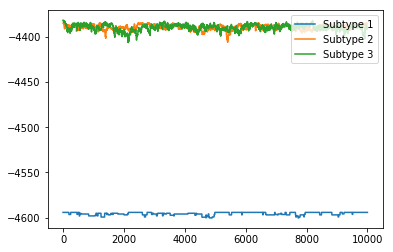

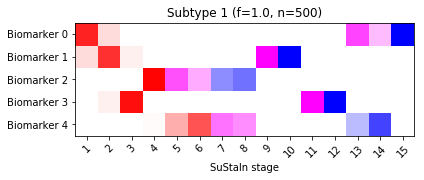

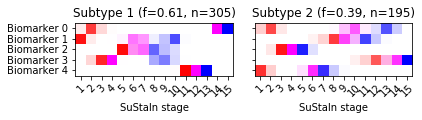

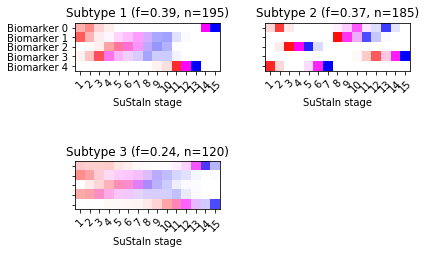

In [8]:
# runs the sustain algorithm with the inputs set in sustain_input above
samples_sequence,   \
samples_f,          \
ml_subtype,         \
prob_ml_subtype,    \
ml_stage,           \
prob_ml_stage,      \
prob_subtype_stage  = sustain_input.run_sustain_algorithm()

Found pickle file: /Volumes/Drafts/2021_SuStaInGitHubTestCases/pySuStaIn-master-frozen/notebooks/sim/pickle_files/sim_subtype0.pickle. Using pickled variables for 0 subtype.
Found pickle file: /Volumes/Drafts/2021_SuStaInGitHubTestCases/pySuStaIn-master-frozen/notebooks/sim/pickle_files/sim_subtype1.pickle. Using pickled variables for 1 subtype.
Found pickle file: /Volumes/Drafts/2021_SuStaInGitHubTestCases/pySuStaIn-master-frozen/notebooks/sim/pickle_files/sim_subtype2.pickle. Using pickled variables for 2 subtype.


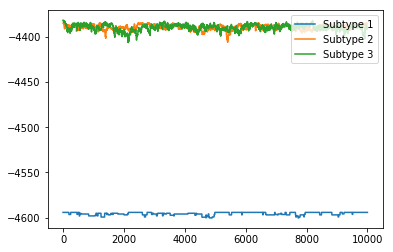

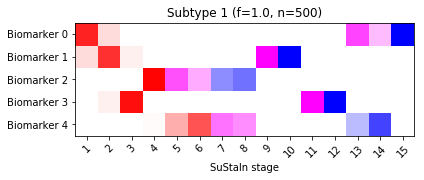

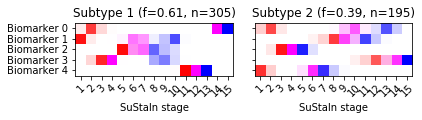

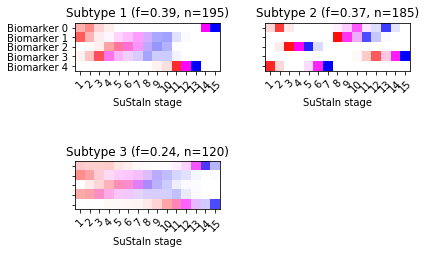

In [9]:
# Just added this to demonstrate what happens if you re-run the SuStaIn algorithm 
# with the same dataset name and folder as previously
# The code recognises the files are there already rather than re-running SuStaIn
# This is useful if you want to increase the number of subtypes without 
# starting right from the beginning again
samples_sequence,   \
samples_f,          \
ml_subtype,         \
prob_ml_subtype,    \
ml_stage,           \
prob_ml_stage,      \
prob_subtype_stage  = sustain_input.run_sustain_algorithm()

## Comparison with ground truth

Figure 3 shows the expected progression patterns for the simulated data in the form of positional variance diagrams so it's easier to compare the output of SuStaIn with the ground truth from the simulated data. In a positional variance diagram each entry tells you the probability each biomarker has reached each z-score at each SuStaIn stage. Here, z-scores of 1 are shown in red, 2 in magenta and 3 in blue. I've plotted the positional variance diagrams in Figure 3 without any uncertainty. You'd expect the results from the simulated dataset to have a similar progression pattern on average to those in Figure 3, but with uncertainty due to the simulated noise. Figure 4 shows the output of SuStaIn for the ground truth number of subtypes.

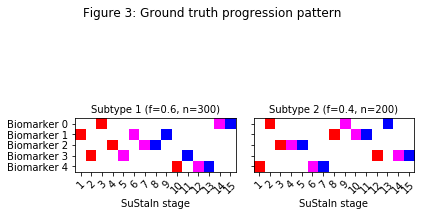

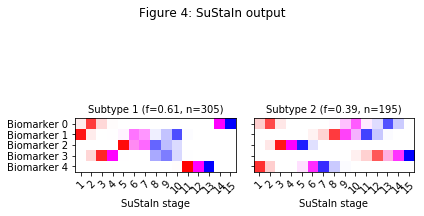

In [10]:
# Output a figure showing the ground truth
temp_gt_sequence = gt_sequence.reshape((gt_sequence.shape[0],gt_sequence.shape[1],1))
temp_gt_f = np.asarray(gt_f).reshape(len(gt_f),1)
pySuStaIn.ZscoreSustain._plot_sustain_model(sustain_input,temp_gt_sequence,temp_gt_f,M)
_ = plt.suptitle('Figure 3: Ground truth progression pattern')

# The code below opens the results for the ground truth number of subtypes
# and plots the output
s = N_S_gt-1
pickle_filename_s           = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pickle_filepath             = Path(pickle_filename_s)
pickle_file                 = open(pickle_filename_s, 'rb')
loaded_variables            = pickle.load(pickle_file)
samples_sequence            = loaded_variables["samples_sequence"]
samples_f                   = loaded_variables["samples_f"]
pickle_file.close()

pySuStaIn.ZscoreSustain._plot_sustain_model(sustain_input,samples_sequence,samples_f,M)
_ = plt.suptitle('Figure 4: SuStaIn output')

## Assessing the output

Now we've run the SuStaIn algorithm, we need to assess the output and decide whether to change any of the settings. 

### MCMC trace

The first thing to look at is the MCMC trace (Figure 5 below). It should be periodic, i.e. with a structure that regularly repeats itself, rather than having long flat sections where it gets stuck at a particular likelihood. If this isn't the case SuStaIn is not working well on your data. There's some troubleshooting you can try:
- Check that your data is z-scored correctly
- Check that the choice of z-scores (Z_vals and Z_max) are sensible
- Check that your data looks normally distributed in your control population
-- if not, try an alternative version of SuStaIn that might be more suitable for your data, e.g. SuStaIn using a KDE event-based model for non normally distributed data 
- Increase the number of startpoints (N_startpoints)
- Increase the number of MCMC samples (N_iterations_MCMC)

### Histograms of model likelihood
The next thing to look at are histograms of the model likelihood (Figure 6 below). Whilst the number of subtypes should be determined through cross-validation, these histograms can give a reasonable indication of the number of subtypes in your dataset, which will enable you to decide whether to fit more subtypes and what to set as the maximum number of subtypes for the cross-validation. When there's a large overlap between the histograms of the model likelihood as you increase the subtypes it means that the likelihood isn't improving very much when you increase the number of subtypes, which means you've probably gone past the optimal number of subtypes. You want to fit enough subtypes so that at least one model is too complex (has too many subtypes) for your data so that you can be sure you've chosen the optimal number of subtypes. If you're not seeing overlapping histograms you need to increase N_S_max and run SuStaIn again from your previous setting of N_S_max.

### Positional variance diagrams
If the end stages of the positional variance diagrams look very blurry with no clear predominant progression pattern, it usually means that there aren't many individuals that fit well with the end stages of the progression. If this is the case you might want to consider removing some biomarker z-scores and re-running SuStaIn.

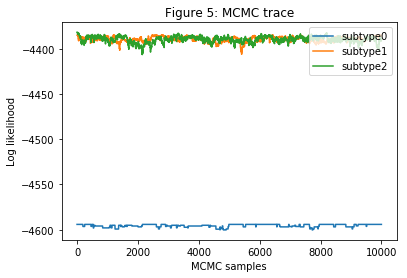

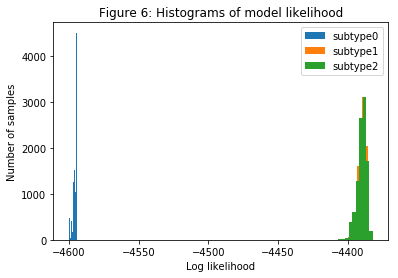

In [11]:
# go through each subtypes model and plot MCMC samples of the likelihood
for s in range(N_S_max):
    pickle_filename_s           = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
    pickle_filepath             = Path(pickle_filename_s)
    pickle_file                 = open(pickle_filename_s, 'rb')
    loaded_variables            = pickle.load(pickle_file)
    samples_likelihood          = loaded_variables["samples_likelihood"]
    pickle_file.close()

    _ = plt.figure(0)
    _ = plt.plot(range(N_iterations_MCMC), samples_likelihood, label="subtype" + str(s))
    _ = plt.figure(1)
    _ = plt.hist(samples_likelihood, label="subtype" + str(s))
    
_ = plt.figure(0)
_ = plt.legend(loc='upper right')
_ = plt.xlabel('MCMC samples')
_ = plt.ylabel('Log likelihood')
_ = plt.title('Figure 5: MCMC trace')
    
_ = plt.figure(1)
_ = plt.legend(loc='upper right')
_ = plt.xlabel('Log likelihood')  
_ = plt.ylabel('Number of samples')  
_ = plt.title('Figure 6: Histograms of model likelihood')

## Cross-validation

To determine the optimal number of subtypes it's necessary to perform cross-validation and compute the cross-validation information criterion (CVIC). 

## Stratified cross-validation
It's a good idea to use stratified training and test sets so you have similar numbers of cases and controls in each fold, as shown below.

In [12]:
# identify a control population
index_control           = np.reshape(gt_stages,(M))==0

# label cases and controls to perform stratified cross-validation
labels                  = 1 * np.ones(data.shape[0], dtype=int) 
labels[index_control]   = 0

# choose the number of folds - here i've used three for speed but i recommend 10 typically
N_folds                  = 3

# generate stratified cross-validation training and test set splits
cv                       = sklearn.model_selection.StratifiedKFold(n_splits=N_folds, 
                                                                   shuffle=True)
cv_it                    = cv.split(data, labels)

test_idxs                = []
for train, test in cv_it:
    test_idxs.append(test)
test_idxs                = np.array(test_idxs)

/Users/alexandrayoung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


## Performing cross-validation

Next you need to run the cross-validation on your training folds and validate on the test folds. The code below does this sequentially for all folds. It's also possible to specify a specific fold if you wanted to run each fold of the cross-validation separately in parallel (e.g. on the cluster).

Finding ML solution to 1 cluster problem
Overall ML likelihood is -3044.7994078757056
Iteration 0 of 10000 , 0 % complete
Iteration 1000 of 10000 , 10 % complete
Iteration 2000 of 10000 , 20 % complete
Iteration 3000 of 10000 , 30 % complete
Iteration 4000 of 10000 , 40 % complete
Iteration 5000 of 10000 , 50 % complete
Iteration 6000 of 10000 , 60 % complete
Iteration 7000 of 10000 , 70 % complete
Iteration 8000 of 10000 , 80 % complete
Iteration 9000 of 10000 , 90 % complete
Iteration 0 of 10000 , 0 % complete
Iteration 1000 of 10000 , 10 % complete
Iteration 2000 of 10000 , 20 % complete
Iteration 3000 of 10000 , 30 % complete
Iteration 4000 of 10000 , 40 % complete
Iteration 5000 of 10000 , 50 % complete
Iteration 6000 of 10000 , 60 % complete
Iteration 7000 of 10000 , 70 % complete
Iteration 8000 of 10000 , 80 % complete
Iteration 9000 of 10000 , 90 % complete
Iteration 0 of 10000 , 0 % complete
Iteration 1000 of 10000 , 10 % complete
Iteration 2000 of 10000 , 20 % complete
Iterat

Iteration 5000 of 10000 , 50 % complete
Iteration 6000 of 10000 , 60 % complete
Iteration 7000 of 10000 , 70 % complete
Iteration 8000 of 10000 , 80 % complete
Iteration 9000 of 10000 , 90 % complete
Iteration 0 of 10000 , 0 % complete
Iteration 1000 of 10000 , 10 % complete
Iteration 2000 of 10000 , 20 % complete
Iteration 3000 of 10000 , 30 % complete
Iteration 4000 of 10000 , 40 % complete
Iteration 5000 of 10000 , 50 % complete
Iteration 6000 of 10000 , 60 % complete
Iteration 7000 of 10000 , 70 % complete
Iteration 8000 of 10000 , 80 % complete
Iteration 9000 of 10000 , 90 % complete
Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-2922.85162885]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-2922.75306283]
Overall ML likelihood is [-2922.75306283]
Iteration 0 of 10000 , 0 % complete
Iteration 1000 of 10000 , 10 %

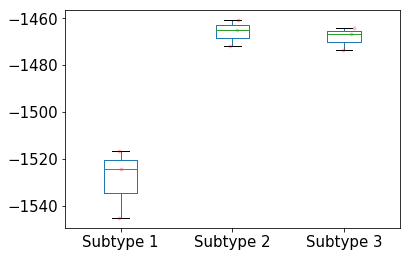

CVIC for each subtype model: [9095.27507133 8755.79936215 8765.39210877]


In [13]:
# perform cross-validation and output the cross-validation information criterion and
# log-likelihood on the test set for each subtypes model and fold combination
CVIC, loglike_matrix     = sustain_input.cross_validate_sustain_model(test_idxs)

Loading /Volumes/Drafts/2021_SuStaInGitHubTestCases/pySuStaIn-master-frozen/notebooks/sim/pickle_files/sim_fold0_subtype0.pickle
Loading /Volumes/Drafts/2021_SuStaInGitHubTestCases/pySuStaIn-master-frozen/notebooks/sim/pickle_files/sim_fold0_subtype1.pickle
Loading /Volumes/Drafts/2021_SuStaInGitHubTestCases/pySuStaIn-master-frozen/notebooks/sim/pickle_files/sim_fold0_subtype2.pickle
Loading /Volumes/Drafts/2021_SuStaInGitHubTestCases/pySuStaIn-master-frozen/notebooks/sim/pickle_files/sim_fold1_subtype0.pickle
Loading /Volumes/Drafts/2021_SuStaInGitHubTestCases/pySuStaIn-master-frozen/notebooks/sim/pickle_files/sim_fold1_subtype1.pickle
Loading /Volumes/Drafts/2021_SuStaInGitHubTestCases/pySuStaIn-master-frozen/notebooks/sim/pickle_files/sim_fold1_subtype2.pickle
Loading /Volumes/Drafts/2021_SuStaInGitHubTestCases/pySuStaIn-master-frozen/notebooks/sim/pickle_files/sim_fold2_subtype0.pickle
Loading /Volumes/Drafts/2021_SuStaInGitHubTestCases/pySuStaIn-master-frozen/notebooks/sim/pickle_

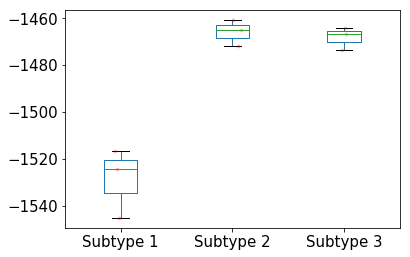

CVIC for each subtype model: [9095.27507133 8755.79936215 8765.39210877]


In [14]:
# Just added this to demonstrate what happens if you re-run the cross-validation 
# with the same dataset name and folder as previously
# The code recognises the files are there already rather than re-running SuStaIn
# This is useful if you want to increase the number of subtypes without 
# starting right from the beginning again

CVIC, loglike_matrix     = sustain_input.cross_validate_sustain_model(test_idxs)

## Choosing the optimal number of subtypes

The optimal number of subtypes is chosen using the CVIC, shown in Figure 7 below. The CVIC is an information criterion (like the AIC/BIC/WAIC) that balances model complexity with model accuracy, with a lower CVIC indicating a better balance between the two. Generally speaking, the model with the lowest CVIC is the best. However, you do sometimes get a very small improvement (less than ~6) in the CVIC with a more complex model, in which case I would tend to favour the less complex (i.e. fewer subtypes) model.

Another useful metric to look at is the log-likelihood of each subtypes model on the test set, shown in Figure 8. A better model should show a consistent improvement in the test set log-likelihood across folds.

CVIC for each subtype model: [9095.27507133 8755.79936215 8765.39210877]
Average test set log-likelihood for each subtype model: [-1528.5969723  -1465.91303053 -1468.19584696]


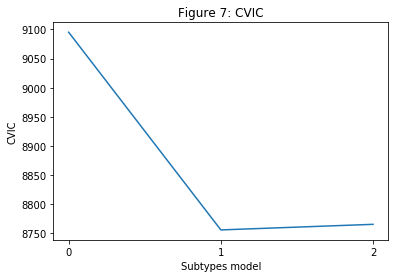

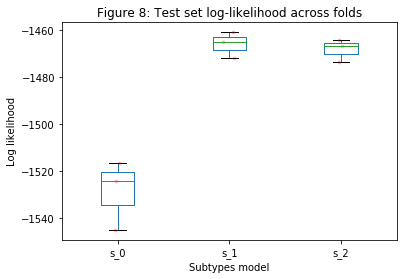

In [15]:
# go through each subtypes model and plot the log-likelihood on the test set and the CVIC
print("CVIC for each subtype model: " + str(CVIC))
print("Average test set log-likelihood for each subtype model: " + str(np.mean(loglike_matrix, 0)))

_ = plt.figure(1)    
_ = plt.plot(np.arange(N_S_max,dtype=int),CVIC)
_ = plt.xticks(np.arange(N_S_max,dtype=int))
_ = plt.ylabel('CVIC')  
_ = plt.xlabel('Subtypes model') 
_ = plt.title('Figure 7: CVIC')

_ = plt.figure(0)
df_loglike                                 = pd.DataFrame(data = loglike_matrix, columns = ["s_" + str(i) for i in range(sustain_input.N_S_max)])
df_loglike.boxplot(grid=False)
for i in range(sustain_input.N_S_max):
    y                                   = df_loglike[["s_" + str(i)]]
    x                                   = np.random.normal(1+i, 0.04, size=len(y)) # Add some random "jitter" to the x-axis
    pylab.plot(x, y, 'r.', alpha=0.2)
_ = plt.ylabel('Log likelihood')  
_ = plt.xlabel('Subtypes model') 
_ = plt.title('Figure 8: Test set log-likelihood across folds')

## Cross-validated positional variance diagrams

Another useful output of the cross-validation that you can look at are positional variance diagrams averaged across cross-validation folds. These give you an idea of the variability in the progression patterns across different training datasets.

/Users/alexandrayoung/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


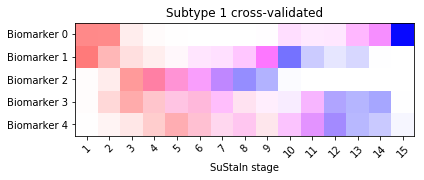

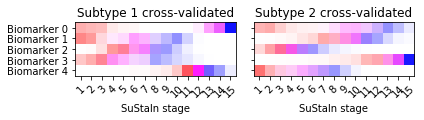

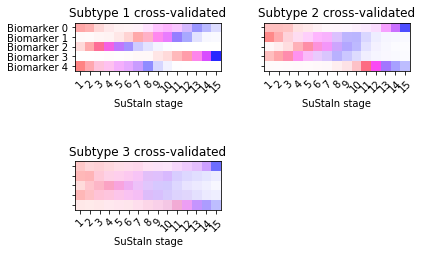

In [16]:
#this part estimates cross-validated positional variance diagrams
for i in range(N_S_max):
    sustain_input.combine_cross_validated_sequences(i+1, N_folds)

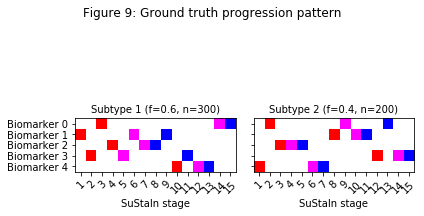

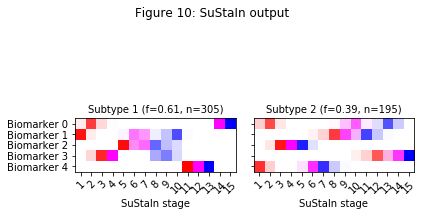

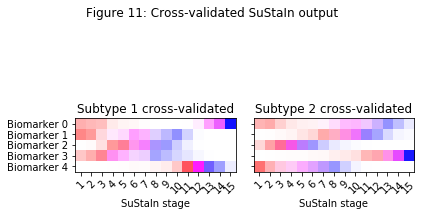

In [17]:
# Output a figure showing the ground truth
temp_gt_sequence = gt_sequence.reshape((gt_sequence.shape[0],gt_sequence.shape[1],1))
temp_gt_f = np.asarray(gt_f).reshape(len(gt_f),1)
pySuStaIn.ZscoreSustain._plot_sustain_model(sustain_input,temp_gt_sequence,temp_gt_f,M)
_ = plt.suptitle('Figure 9: Ground truth progression pattern')

# The code below opens the results for the ground truth number of subtypes
# and plots the output
s = N_S_gt-1
pickle_filename_s           = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pickle_filepath             = Path(pickle_filename_s)
pickle_file                 = open(pickle_filename_s, 'rb')
loaded_variables            = pickle.load(pickle_file)
samples_sequence            = loaded_variables["samples_sequence"]
samples_f                   = loaded_variables["samples_f"]
pickle_file.close()

pySuStaIn.ZscoreSustain._plot_sustain_model(sustain_input,samples_sequence,samples_f,M)
_ = plt.suptitle('Figure 10: SuStaIn output')

sustain_input.combine_cross_validated_sequences(N_S_gt, N_folds)
_ = plt.suptitle('Figure 11: Cross-validated SuStaIn output')

## Subtyping and staging

Once you've used the CVIC to choose the optimal number of subtypes you can use the SuStaIn output from that subtypes model to subtype and stage individuals in your dataset. This will already have been output by the SuStaIn algorithm, you can extract the outputs using the code below. The outputs are

### ml_subtype and prob_ml_subtype
The maximum likelihood subtype and the probability of that subtype for each individual.

### ml_stage and prob_ml_stage
The maximum likelihood stage and the probability of that stage for each individual.

### prob_subtype, prob_stage and prob_subtype_stage
The probability each individual belongs to each subtype, to each stage, and to each subtype and stage combination.

In [18]:
s = N_S_gt-1
pickle_filename_s           = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pickle_filepath             = Path(pickle_filename_s)
pickle_file                 = open(pickle_filename_s, 'rb')
loaded_variables            = pickle.load(pickle_file)
ml_subtype                  = loaded_variables["ml_subtype"]
prob_ml_subtype             = loaded_variables["prob_ml_subtype"]
ml_stage                    = loaded_variables["ml_stage"]
prob_ml_stage               = loaded_variables["prob_ml_stage"]
prob_subtype                = loaded_variables["prob_subtype"]
prob_stage                  = loaded_variables["prob_stage"]
prob_subtype_stage          = loaded_variables["prob_subtype_stage"]
pickle_file.close()              

# You can also subtype and stage new data using
# N_samples                       = 1000
# ml_subtype,                  \
# prob_ml_subtype,             \
# ml_stage,                    \
# prob_ml_stage,               \
# prob_subtype,                \
# prob_stage,                  \
# prob_subtype_stage          = sustain_input.subtype_and_stage_individuals_newData(new_data,
#                                                                                   samples_sequence,
#                                                                                   samples_f,
#                                                                                   N_samples)

## Subtyping and staging using cross-validated models

The code below subtypes and stages individuals using the cross-validated positional variance diagrams in Figure 11.

In [19]:
s = N_S_gt-1
Nfolds                              = len(test_idxs)
for fold in range(Nfolds):
    pickle_filename_fold_s  = sustain_input.output_folder + '/pickle_files/' + sustain_input.dataset_name + '_fold' + str(fold) + '_subtype' + str(s) + '.pickle'
    pickle_filepath         = Path(pickle_filename_fold_s)

    pickle_file             = open(pickle_filename_fold_s, 'rb')

    loaded_variables        = pickle.load(pickle_file)

    samples_sequence        = loaded_variables["samples_sequence"]
    samples_f               = loaded_variables["samples_f"]
    
    pickle_file.close()
    
    if fold == 0:
        samples_sequence_cval    = samples_sequence
        samples_f_cval           = samples_f
    else:
        samples_sequence_cval    = np.concatenate((samples_sequence_cval, samples_sequence), axis=2)
        samples_f_cval           = np.concatenate((samples_f_cval, samples_f), axis=1)
                    
N_samples                       = 1000
ml_subtype_cval,             \
prob_ml_subtype_cval,        \
ml_stage_cval,               \
prob_ml_stage_cval,          \
prob_subtype_cval,           \
prob_stage_cval,             \
prob_subtype_stage_cval          = sustain_input.subtype_and_stage_individuals_newData(data,
                                                                                       samples_sequence_cval,
                                                                                       samples_f_cval,
                                                                                       N_samples)